# Bootstrap region s24 and s32 to all other ROI centroids

This script bootstraps the following differences:
* Ketamine-Baseline
* Placebo-Baseline
* (Ketamine-Baseline) - (Placebo-Baseline)

for regions s24 and s32 that were previously chosen due to the results of the within-ROI analysis.
Then the mean of these bootstrap results is taken and depicted in heatmap to cpmare the conditions


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import scipy
import seaborn as sns
import os
import pickle
import copy
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats
import scipy.stats as st

Load dataframes containing the distance values from each voxel to all ROI centroids

In [2]:
p = np.load('/Users/jenniferthem/Masterthesis_Data/January2020/voxel_all_centroids_placebo', allow_pickle=True)
b_p = np.load('/Users/jenniferthem/Masterthesis_Data/January2020/voxel_all_centroids_baseline_p', allow_pickle=True)
k = np.load('/Users/jenniferthem/Masterthesis_Data/January2020/voxel_all_centroids_ketamine', allow_pickle=True)
b_k = np.load('/Users/jenniferthem/Masterthesis_Data/January2020/voxel_all_centroids_baseline_ket', allow_pickle=True)
roi_labels = np.load('/Users/jenniferthem/Masterthesis_Data/roi_labels.npy', allow_pickle=True)

In [3]:
p

,OFC1,OFC2,OFC3,OFC4,OFC5,OFC6,OFC7,s32,FP2,25,s24,33,p32,p24ab,p24c,Putamen,NAcc,Caudate
0,0.226733,0.422894,1.335219,3.148752,2.788927,4.410674,3.748523,2.748099,5.059959,0.679296,2.755289,2.890687,6.181243,5.461668,6.185415,9.863185,8.398568,8.339620
1,0.528746,0.516267,1.025515,2.843058,2.484603,4.096969,3.428747,3.055861,5.381871,0.723912,3.058456,3.131667,6.498226,5.764049,6.494627,9.698022,8.175587,8.085256
2,0.182466,0.659102,1.453361,3.124055,2.763164,4.401328,3.760737,2.795300,5.052827,0.915925,2.812625,3.028825,6.194837,5.513580,6.221405,10.085056,8.596735,8.517674
3,0.454224,0.563894,1.115213,2.870370,2.510544,4.133254,3.474313,3.026470,5.333057,0.791139,3.033285,3.144631,6.458054,5.739689,6.463776,9.806347,8.283055,8.189319
4,0.529827,0.909140,2.056627,3.812401,3.451538,5.090403,4.446981,2.129434,4.363946,1.102069,2.156257,2.509102,5.507191,4.844483,5.541670,10.336788,8.981193,8.975653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11878,8.106480,7.649629,6.603138,6.290796,6.438685,5.681016,5.553036,9.869950,12.269585,7.498972,9.799138,9.078177,13.086680,12.014162,12.833250,4.696659,2.204799,1.095627
11879,8.096053,7.638746,6.593255,6.284916,6.432130,5.677748,5.547953,9.857620,12.256955,7.487832,9.786733,9.065178,13.073574,12.000829,12.819908,4.688725,2.195998,1.090209
11880,8.083270,7.625710,6.580792,6.275234,6.421938,5.670165,5.538893,9.843915,12.243145,7.474662,9.773000,9.051268,13.059641,11.986859,12.805937,4.685505,2.191822,1.089854
11881,8.084783,7.627735,6.581721,6.272495,6.419757,5.665441,5.535518,9.847746,12.247403,7.476984,9.776936,9.056084,13.064628,11.992230,12.811324,4.695954,2.202490,1.099344


In [4]:
# prepare roi labels 
roi_list = []
for i in range(len(roi_labels)):
    roi_list.append(copy.deepcopy(roi_labels[i][0]))

In [5]:
# label the voxels
p['label']= roi_list
b_p['label']= roi_list
k['label']= roi_list
b_k['label']= roi_list

In [6]:
# list of the ROIs
rois = ['OFC1','OFC2','OFC3','OFC4','OFC5','OFC6','OFC7','s32','FP2','25','s24','33','p32','p24ab','p24c','Putamen','NAcc','Caudate']

Extracting of only s24 and s32 voxels + dropping the label columns

In [7]:
s24_b_k = b_k[b_k['label']=='s24'].drop(['label'], axis=1)
s24_k = k[k['label']=='s24'].drop(['label'], axis=1)
s24_p = p[p['label']=='s24'].drop(['label'], axis=1)
s24_b_p = b_p[b_p['label']=='s24'].drop(['label'], axis=1)

In [8]:
s32_b_k = b_k[b_k['label']=='s32'].drop(['label'], axis=1)
s32_k = k[k['label']=='s32'].drop(['label'], axis=1)
s32_p = p[p['label']=='s32'].drop(['label'], axis=1)
s32_b_p = b_p[b_p['label']=='s32'].drop(['label'], axis=1)

Calculating the differences as preparation for bootstrap

In [10]:
# ketamine - baseline
s24_k_sub_b = s24_k - s24_b_k
# placebo - baseline
s24_p_sub_b = s24_p - s24_b_p
# (ketamine-b) - (placebo-b)
s24_k_p = s24_k_sub_b - s24_p_sub_b

In [11]:
# ketamine - baseline
s32_k_sub_b = s32_k - s32_b_k
# placebo - baseline
s32_p_sub_b = s32_p - s32_b_p
# (ketamine-b) - (placebo-b)
s32_k_p = s32_k_sub_b - s32_p_sub_b

In [17]:
np.asarray(s24_k_sub_b['OFC1'])

array([-0.28367793, -0.21739685, -0.42245208, -0.59763346, -0.35400253,
       -0.04073392,  0.1621548 , -0.35027662, -0.61478763, -0.20470952,
       -0.04323078, -0.11649534,  0.0274907 , -0.09531477, -2.50578913,
        0.01650524, -0.32726157, -0.06572374, -2.06432901,  0.02379166,
       -0.31749548, -0.13972897, -0.33449304, -0.06979775, -0.47263738,
       -0.25079989, -0.11202746, -0.3850429 ,  0.04159964,  0.05896364,
        2.73916845, -0.52675495, -1.20749812, -0.8174413 , -0.21951608,
        5.62410156,  2.01238352,  3.38987405, -1.42366121,  4.74427887,
       -0.5315764 ,  2.11762811,  2.33062611,  2.85353795,  3.63987703,
        2.7866179 , -0.58690526, -0.74239207, -0.08510712, -0.12199154,
        0.56539402, -2.06426889,  5.76441222, -0.24325278,  0.26750962,
        5.70890276,  2.97295205,  4.3555038 ,  4.97582069,  4.67389469,
        2.55211604,  2.9489086 ,  3.43017259,  2.85146538,  3.79008389,
        4.5307589 ,  0.95830157, -6.1671968 ,  2.59517681,  2.20

**Function to bootstrap the differences**: each region needs to be bootstrapped separately. So output would be a matrix with 18 rows and 50 000 bootstraps. And we would get 3 of them for all conditions.

In [23]:
#input differences between (ketamine - baseline), (placebo - baseline) and (ketamine-placebo) dfs
def calculate_bootstrap(dist_k, dist_p, dist):
    rois = ['OFC1','OFC2','OFC3','OFC4','OFC5','OFC6','OFC7','s32','FP2','25','s24','33','p32','p24ab','p24c','Putamen','NAcc','Caudate']
    k_dict={}
    p_dict={}
    k_p_dict={}
    for roi in rois:
        
        # Bootstrap 50 000 iterations
        # returns bootstrap distribution
        bsr_k_b = bs.bootstrap(np.asarray(dist_k[roi]), stat_func=bs_stats.mean, alpha=0.05, num_iterations=50000, return_distribution=True)
        bsr_p_b = bs.bootstrap(np.asarray(dist_p[roi]), stat_func=bs_stats.mean, alpha=0.05, num_iterations=50000, return_distribution=True)
        bsr = bs.bootstrap(np.asarray(dist[roi]), stat_func=bs_stats.mean, alpha=0.05, num_iterations=50000, return_distribution=True)
        
        # fill dictionaries with ROI: bootstrap list --> 18 x 50.000 
        k_dict[roi] = copy.deepcopy(bsr_k_b)
        p_dict[roi] = copy.deepcopy(bsr_p_b)
        k_p_dict[roi] = copy.deepcopy(bsr)
        

    return k_dict, p_dict, k_p_dict

In [24]:
[k_dict_s24, p_dict_s24, k_p_dict_s24]= calculate_bootstrap(s24_k_sub_b,s24_p_sub_b,s24_k_p)

In [25]:
[k_dict_s32, p_dict_s32, k_p_dict_s32]= calculate_bootstrap(s32_k_sub_b,s32_p_sub_b,s32_k_p)

Prepare dataframes of bootstrap results

In [39]:
k_dict_s24_df =pd.DataFrame(k_dict_s24)
p_dict_s24_df =pd.DataFrame(p_dict_s24)
k_p_dict_s24_df =pd.DataFrame(k_p_dict_s24)

In [40]:
k_dict_s32_df=pd.DataFrame(k_dict_s32)
p_dict_s32_df =pd.DataFrame(p_dict_s32)
k_p_dict_s32_df =pd.DataFrame(k_p_dict_s32)

### Heatmap for s32 placebo and ketamine for all bootstraps

<IPython.core.display.Javascript object>


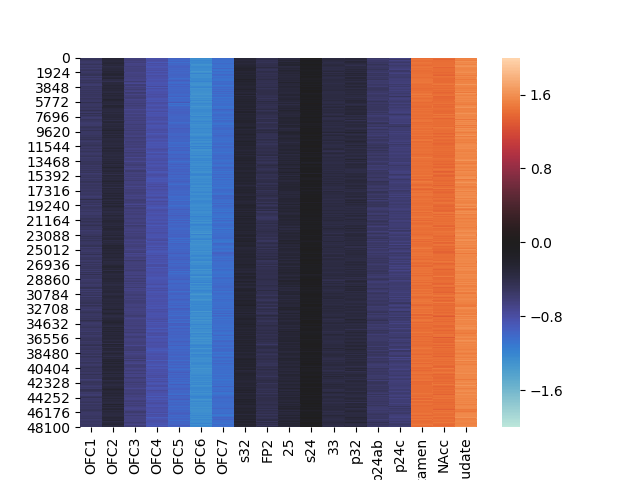

In [37]:
%matplotlib notebook
sns.heatmap(p_dict_s32_df, vmin=-2, vmax=2, center=0)
plt.savefig('/Users/jenniferthem/Masterthesis_Data/Bootstrap/bootstrap_heatmap_placebo_s32', dpi=250)

<IPython.core.display.Javascript object>


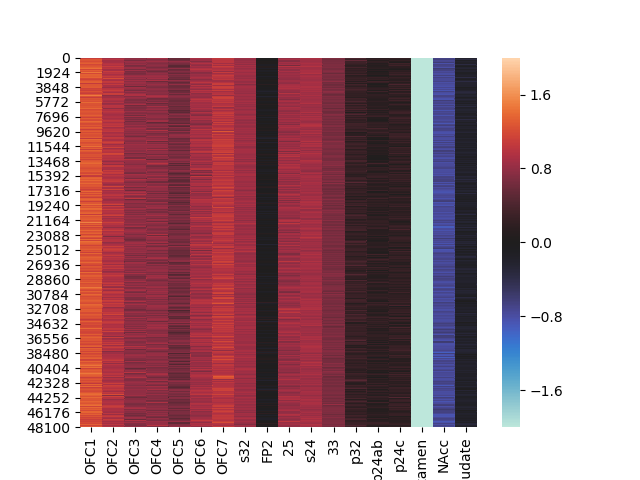

In [38]:
%matplotlib notebook
sns.heatmap(k_dict_s32_df, vmin=-2, vmax=2, center=0)
plt.savefig('/Users/jenniferthem/Masterthesis_Data/Bootstrap/bootstrap_heatmap_ketamine_s32', dpi=250)

<IPython.core.display.Javascript object>


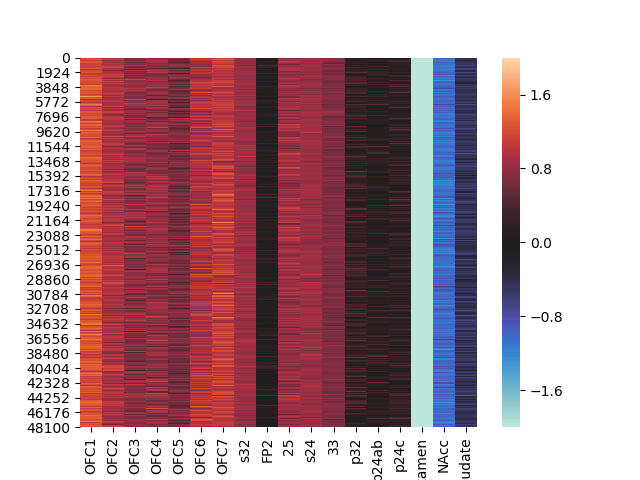

In [33]:
%matplotlib notebook
sns.heatmap(k_dict_s24_df, vmin=-2, vmax=2, center=0)

### Heatmap for s24 and s32 with all 3 conditions combined

Calculate mean of bootstrap distribution

In [42]:
k_dict_s24_mean =np.mean(k_dict_s24_df)
p_dict_s24_mean =np.mean(p_dict_s24_df)
k_p_dict_s24_mean =np.mean(k_p_dict_s24_df)

In [43]:
k_dict_s32_mean =np.mean(k_dict_s32_df)
p_dict_s32_mean =np.mean(p_dict_s32_df)
k_p_dict_s32_mean =np.mean(k_p_dict_s32_df)

In [53]:
k_s24= pd.DataFrame(k_dict_s24_mean, columns=['Bootstrap_mean'])
p_s24= pd.DataFrame(p_dict_s24_mean, columns=['Bootstrap_mean'])
k_p_s24= pd.DataFrame(k_p_dict_s24_mean, columns=['Bootstrap_mean'])

In [52]:
k_s32= pd.DataFrame(k_dict_s32_mean, columns=['Bootstrap_mean'])
p_s32= pd.DataFrame(p_dict_s32_mean, columns=['Bootstrap_mean'])
k_p_s32= pd.DataFrame(k_p_dict_s32_mean, columns=['Bootstrap_mean'])

Concatenate all conditions

In [57]:
s24_df = pd.concat([k_s24, p_s24, k_p_s24], axis=1)
s24_df.columns=['Ketamine', 'Placebo', 'Ketamine-Placebo']
s24_df

,Ketamine,Placebo,Ketamine-Placebo
OFC1,1.229895,-0.880468,2.109204
OFC2,0.945121,-0.637207,1.583175
OFC3,0.766597,-0.979559,1.744293
OFC4,0.799965,-1.170224,1.969949
OFC5,0.659224,-1.325951,1.984764
OFC6,0.934614,-1.625508,2.560085
OFC7,1.066781,-1.400026,2.466133
s32,0.837393,-0.331551,1.169147
FP2,0.063149,-0.135627,0.198840
25,0.855727,-0.593428,1.448558


In [59]:
s32_df = pd.concat([k_s32, p_s32, k_p_s32], axis=1)
s32_df.columns=['Ketamine', 'Placebo', 'Ketamine-Placebo']
s32_df

,Ketamine,Placebo,Ketamine-Placebo
OFC1,1.256646,-0.513611,1.769609
OFC2,0.977929,-0.304314,1.281754
OFC3,0.776806,-0.635055,1.411757
OFC4,0.767183,-0.825762,1.593251
OFC5,0.638858,-0.974176,1.612755
OFC6,0.884749,-1.239538,2.123363
OFC7,1.018519,-1.029674,2.048689
s32,0.859793,-0.241616,1.101407
FP2,-0.027219,-0.421729,0.393678
25,0.840585,-0.275578,1.115743


## Heatmaps

### s24

<IPython.core.display.Javascript object>


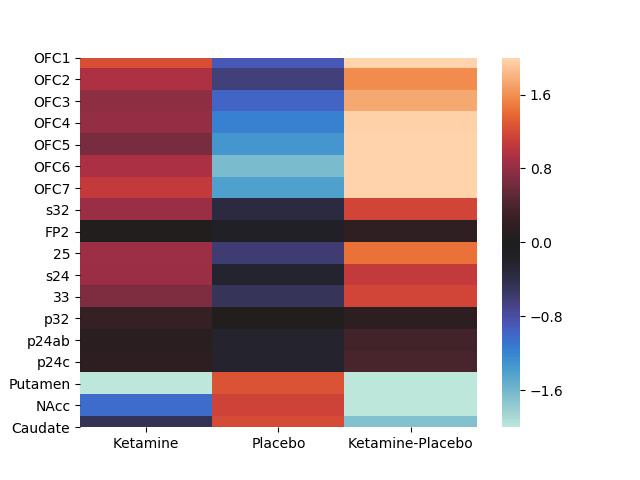

In [62]:
%matplotlib notebook
sns.heatmap(s24_df, vmin=-2, vmax=2, center=0)
plt.savefig('/Users/jenniferthem/Masterthesis_Data/Bootstrap/bootstrap_heatmap_s24', dpi=250)

### s32

<IPython.core.display.Javascript object>


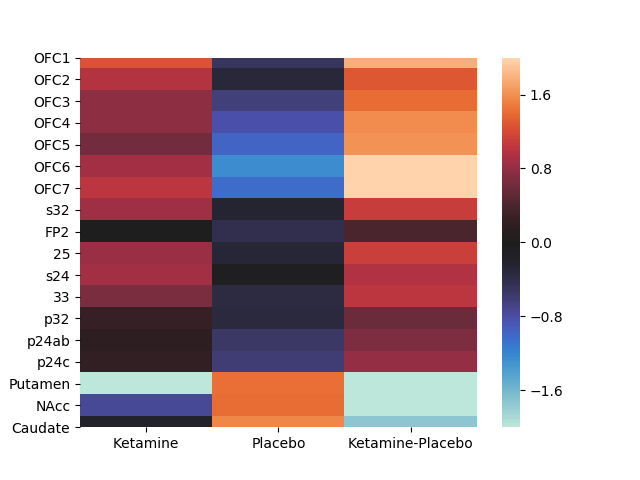

In [63]:
%matplotlib notebook
sns.heatmap(s32_df, vmin=-2, vmax=2, center=0)
plt.savefig('/Users/jenniferthem/Masterthesis_Data/Bootstrap/bootstrap_heatmap_s32', dpi=250)